In [377]:
### X IS NOT THE IDENTITY MATRIX
### alpha_i = 1

# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [378]:
n_realizations = 2 # number of repeated experiments
N = 200 # number of observations
D =  50 # length of true beta 

beta = np.zeros(D)
beta[:5] = [2, -1, 0.5, 5, -4] 
beta += np.random.normal(0, 0.1, size=[D]) # add noise 

A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # signal magnitude
lams = [2, 1, 1/2, 1/100] # temperature coefficients

prng_key = random.PRNGKey(2) # pseudo random number key


<h1> Generating Data </h1>

$$\begin{align*}
y_i &= x_i\cdot\beta_i + \epsilon_i\\
x_i &\sim N(0, 1) \text{ for } i = 1, ..., D\\
\beta_1 &= 2 \\
\beta_2 &= -1 \\
\beta_3 &= 0.5 \\
\beta_4 &= 5 \\
\beta_5 &= -4 \\
\beta_j &= 0 \text{ for } j = 6, ..., D \\
\epsilon_i &\sim N(0, 0.1) \text{ for } i = 1, ..., D\\
\end{align*}$$

In [379]:
def generate_data(A):
    assert D >= 5
    X = np.random.randn(N, D)*A 
    Y = jnp.dot(X, beta)
    Y += np.random.normal(0, 0.1, size=[N])
    return X, Y

<h2> Defining the Model </h2>

$$\begin{align*} 
\gamma_i &= \sigma ((L_i + \log(\alpha_i)) / \lambda) \text{  for   } i = 1, ..., n \\
L_i &= \log (U_i) - \log (1-U_i)\\
U_i &\sim \text{Uniform}(0, 1)
\end{align*}$$




In this example, $\alpha_i$ is assumed to be $1$.
In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [380]:
def model(alphas, lam, X=None, Y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter
       array X: input data
       array Y: output data
    '''
    U = numpyro.sample("U", dist.Uniform(0, 1).expand([D])) #Dx1
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1 - U)) #Dx1
    gammas = numpyro.deterministic("gammas", sigmoid((L + jnp.log(alphas)) / lam)) #Dx1
    kappas = numpyro.deterministic("kappas", 1 - gammas) #Dx1
    betas = numpyro.sample("betas", dist.Normal(0, 1).expand([D])) #Dx1
    scaled_betas = gammas * betas #Dx1
    y_mean = jnp.dot(X, scaled_betas)
    y = numpyro.sample("Y", dist.Normal(y_mean, 0.1), obs=Y)
    

In [381]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=500, num_samples=1000, num_chains=1, progress_bar=False)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [382]:
def concrete(all_data, lam):
    beta_samples = {}
    kappa_samples = []
    mean_sq_errors = [0]*11
    mean_gamma_samples = [0]*11

    for A, (X, Y) in all_data.items():

        alphas = jnp.ones(D)
        mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, Y=Y)
        
        samples = mcmc.get_samples()

        mean_gamma_samples[A] = (samples['gammas'].mean(axis=0)) # mean across all samples in one mcmc run

        beta_samples[A] = mean_gamma_samples[A] * beta

        mean_sq_errors[A] = jnp.mean((beta_samples[A] - beta)**2)
        
        kappa_samples.extend(samples['kappas'])
    
    return mean_sq_errors, kappa_samples, mean_gamma_samples, beta_samples, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [383]:
all_mse_values = dict()
mean_mse_values = dict()
all_kappas = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []
all_data = {}

for A in A_values:
    all_data[A] = generate_data(A) 

for lam in lams:
    mean_sq_errors, kappas, mean_gammas_lam, beta_samples, samples, mcmc = concrete(all_data, lam=lam)

    all_mse_values[lam] = []
    all_mse_values[lam].append(np.array(mean_sq_errors))
    mean_mse_values[lam] = np.mean(all_mse_values[lam], axis=0)

    all_kappas[lam] = kappas
    mean_gammas[lam] = mean_gammas_lam
    mean_betas[lam] = beta_samples

    all_mcmc_runs.append(mcmc)


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [384]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.89      0.11      0.92      0.75      1.00     82.69      1.00
      U[1]      0.71      0.20      0.75      0.40      1.00     49.24      1.06
      U[2]      0.51      0.26      0.50      0.12      0.93     50.09      1.02
      U[3]      0.99      0.01      0.99      0.98      1.00     47.72      1.00
      U[4]      0.99      0.02      0.99      0.96      1.00     35.06      1.03
      U[5]      0.39      0.30      0.35      0.00      0.84     51.69      1.00
      U[6]      0.33      0.30      0.26      0.01      0.82     51.81      1.01
      U[7]      0.38      0.27      0.33      0.02      0.81    124.49      1.01
      U[8]      0.42      0.28      0.34      0.05      0.89     43.42      1.00
      U[9]      0.42      0.27      0.38      0.01      0.83    193.00      1.00
     U[10]      0.52      0.28      0.52      0.10      0.95     47.14      1.02
     U[11]      0.40      0

<h1> Results </h1>

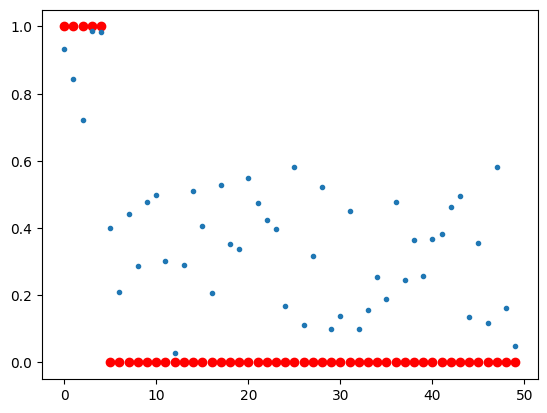

In [396]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 5), layout="tight")

true_gamma = np.zeros(D)
true_gamma[:5] = 1

plt.plot(range(D), true_gamma, 'ro')
# plt.plot(range(D), mean_gammas[2], '.')
plt.plot(range(D), np.array(mean_gammas[1/2][1:]).mean(axis=0), '.')

# for lam in [2, 1/100]:
#     ax.scatter(range(D), mean_gammas[lam], s=10, alpha = 0.5)

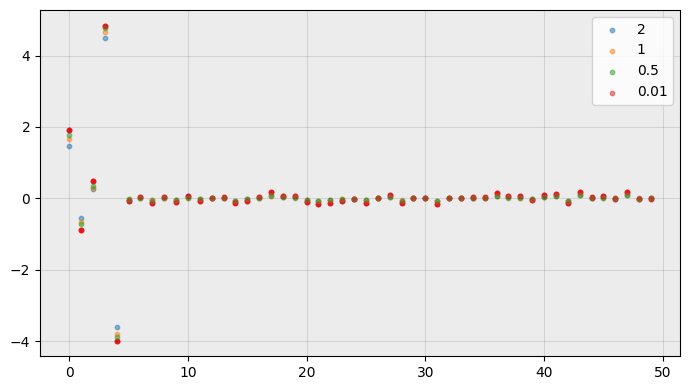

In [397]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), layout="tight")

ax.set_facecolor("#ECECEC") # set graph background color to grey
ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

ax.scatter(range(D), beta, color='red', s=10) # plot actual betas
for lam in lams:
    ax.scatter(range(D), mean_betas[lam][1], s=10, alpha=0.5, label=lam)

# add labels to graph
plt.legend()


As $\lambda$ decreases, mean squared error decreases.

Text(0.5, 1.0, 'Mean Squared Error for Different Lambda Values')

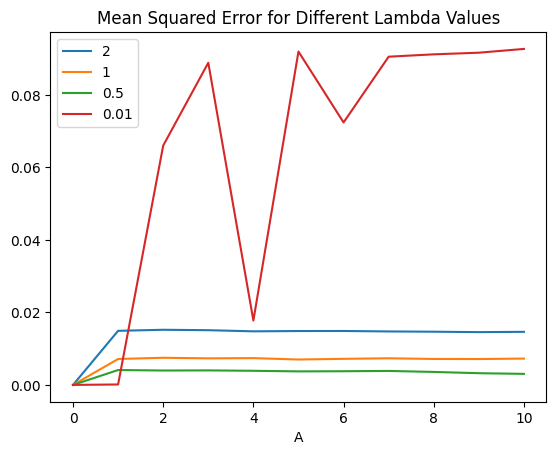

In [398]:
for lam in [2, 1, 0.5, 0.01]:
    plt.plot(range(len(mean_mse_values[lam])), mean_mse_values[lam], label=f'{lam}')
ax = plt.gca()
plt.legend()
plt.xlabel("A")
plt.title("Mean Squared Error for Different Lambda Values")

As the value of $\lambda$ decreases, the distribution of $\kappa$ values becomes more concentrated around $0$ and $1$.

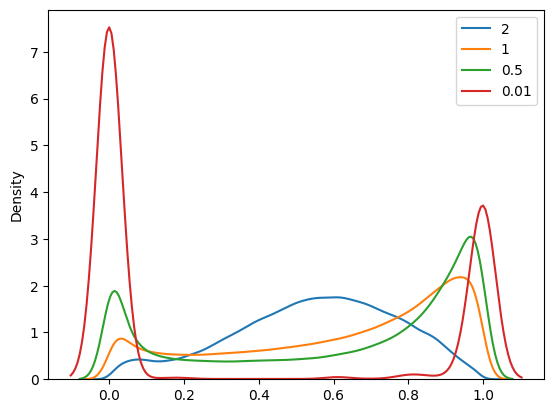

In [399]:
for lam in lams:
    all_kappas[lam] = np.ndarray.flatten(np.array(all_kappas[lam]))
    sns.kdeplot(all_kappas[lam], label=f'{lam}')
plt.legend()